In [1]:
import os, sys

sys.path.append('..')
from script.utils import *
from Class.PlotConfig import *

In [2]:
target_df = None
merge_keys = ['FIPS', 'Date']

first_date = to_datetime('02-28-2020')
last_date = to_datetime('05-17-2022')
dataPath = '../../dataset_raw/CovidMay17-2022/'

targets = ['Cases', 'Deaths']
for feature_name in targets:
    file_name = f'{feature_name}.csv'


    print(f'Reading {file_name}')
    df = read_feature_file(dataPath, file_name)
    
    # check whether the Date column has been pivoted
    if 'Date' not in df.columns:
        df = convert_cumulative_to_daily(df)
        df.fillna(0, inplace=True)
        # df = remove_outliers(df, verbose=False)

        # technically this should be set of common columns
        id_vars = [col for col in df.columns if not valid_date(col)]
        df = df.melt(
            id_vars= id_vars,
            var_name='Date', value_name=feature_name
        ).reset_index(drop=True)
    else:
        df.fillna(0, inplace=True)
        # df = remove_outliers(df, verbose=False)

    # some days had old covid cases fixed by adding neg values
    df.loc[df[feature_name]<0, feature_name] = 0
    
    # can be needed as some feature files may have different date format
    df['Date'] = to_datetime(df['Date'])
    print(f'Min date {df["Date"].min()}, max date {df["Date"].max()}')
    df = df[(first_date <= df['Date']) & (df['Date']<= last_date)]

    print(f'Length {df.shape[0]}.')

    if target_df is None: target_df = df
    else:
        # if a single file has multiple features
        if type(feature_name) == list:
            selected_columns = merge_keys + feature_name
        else:
            selected_columns = merge_keys + [feature_name]

        target_df = target_df.merge(df[selected_columns], how='outer',on=merge_keys)

        # however, we don't need to keep mismatch of FIPS
        target_df = target_df[~target_df['FIPS'].isna()]
    print()

Reading Cases.csv
Min date 2020-01-22 00:00:00, max date 2022-05-25 00:00:00
Length 2545020.

Reading Deaths.csv
Min date 2020-01-22 00:00:00, max date 2022-05-15 00:00:00
Length 2538736.



In [3]:
target_df.describe()

,FIPS,Cases,Deaths
count,2.545020e+06,2.545020e+06,2.538736e+06
mean,3.038365e+04,3.162784e+01,3.780515e-01
std,1.516010e+04,3.371987e+02,2.854735e+00
min,1.001000e+03,0.000000e+00,0.000000e+00
25%,1.817700e+04,0.000000e+00,0.000000e+00
50%,2.917600e+04,1.000000e+00,0.000000e+00
75%,4.508100e+04,1.200000e+01,0.000000e+00
max,5.604500e+04,1.864080e+05,7.070000e+02


In [4]:
targets = ['Cases', 'Deaths']
target_df = target_df.groupby(['Date'])[targets].aggregate('sum').reset_index()

target_df.head()

,Date,Cases,Deaths
0,2020-02-28,25,0.0
1,2020-02-29,62,1.0
2,2020-03-01,46,0.0
3,2020-03-02,114,5.0
4,2020-03-03,91,1.0


In [5]:
target_df.describe()

,Cases,Deaths
count,8.100000e+02,810.000000
mean,9.937469e+04,1184.904938
std,1.451092e+05,950.847686
min,2.500000e+01,0.000000
25%,2.965150e+04,464.000000
50%,5.504350e+04,919.000000
75%,1.181405e+05,1642.500000
max,1.362269e+06,5094.000000


In [6]:
figPath = '../results/'

def plot(df, target, scale_y:int=1e3, x_major_ticks:int=DATE_TICKS, figure_name:str=None):
    fig, ax = plt.subplots(figsize=FIGSIZE)
    x_column = 'Date'

    plt.plot(df[x_column], df[target])
    plt.ylim(bottom=0)

    x_first_tick = df[x_column].min()
    x_last_tick = df[x_column].max()
    ax.set_xticks(
        [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
    )
    plt.xticks(rotation = 45)
        
    if scale_y > 1:
        ax.yaxis.set_major_formatter(get_formatter(scale_y))
        
        if scale_y==1e3: unit = 'in thousands'
        elif scale_y==1e6: unit = 'in millions'
        else: unit = f'x {scale_y:.0e}'

        plt.ylabel(f'Daily {target} ({unit})')
    else:
        plt.ylabel(f'Daily {target}')

    fig.tight_layout()

    if figure_name is not None:
        plt.savefig(os.path.join(figPath, figure_name), dpi=DPI)
    plt.show()

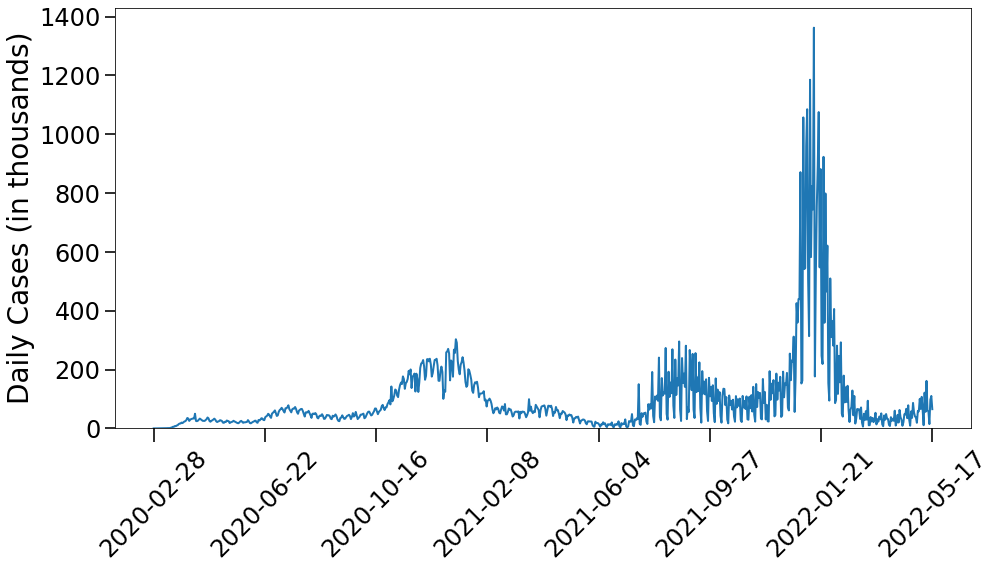

In [7]:
plot(target_df, 'Cases', figure_name='Cases-original.jpg')

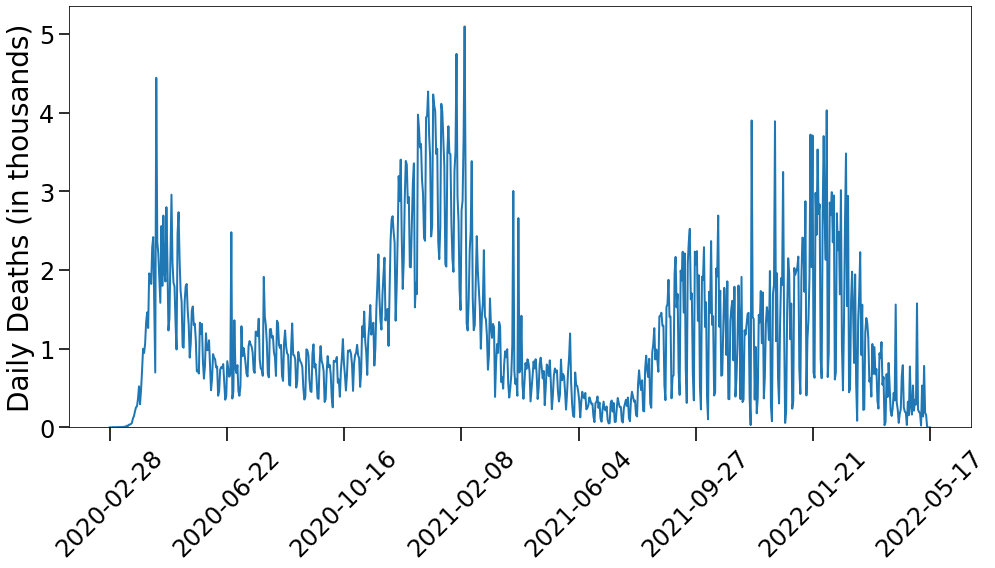

In [8]:
plot(target_df, 'Deaths', figure_name='Deaths-original.jpg')

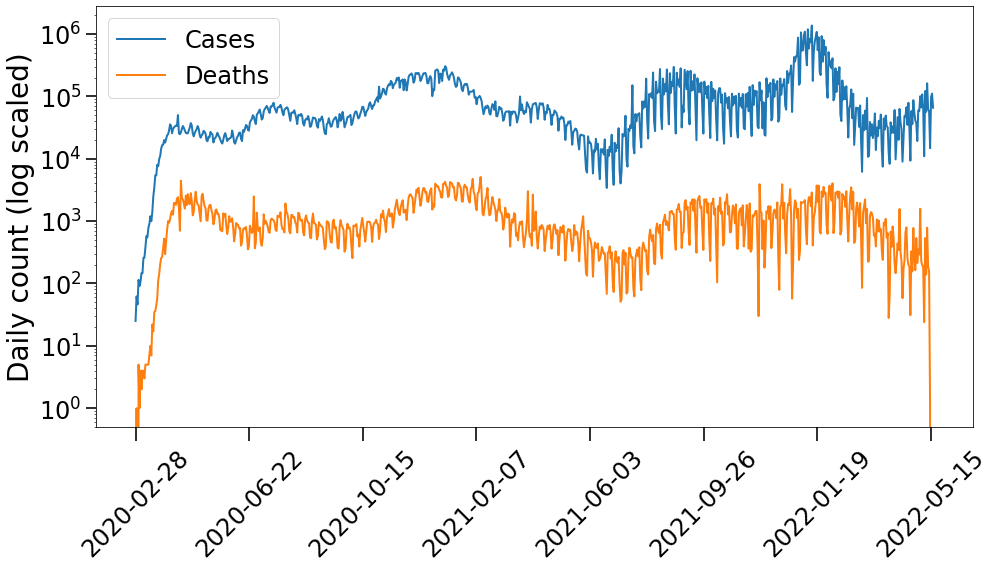

In [9]:
fig, ax = plt.subplots(figsize=FIGSIZE)

for target in targets:
    plt.plot(target_df['Date'], target_df[target], label=target)

x_first_tick = df['Date'].min()
x_last_tick = df['Date'].max()
x_major_ticks = DATE_TICKS
ax.set_xticks(
    [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
)
plt.xticks(rotation = 45)
plt.yscale('log')
plt.ylabel(f'Daily count (log scaled)')

plt.legend()
fig.tight_layout()
plt.savefig(os.path.join(figPath, 'Combined-log-scaled.jpg'), dpi=DPI)
plt.show()

In [10]:
# train_start = to_datetime('03-10-2020')
# validation_start = to_datetime('01-15-2022')
# test_start= to_datetime('04-16-2022')
# test_end = to_datetime('07-28-2022')

# train_days = (validation_start - train_start).days
# val_days = (test_start  - validation_start).days
# test_days = (test_end - test_start).days + 1
# train_days,train_days%13, val_days,val_days%13, test_days, test_days%13